# Building a Recommender System from Scratch

### What is a recommender?

### How do you build a recommender?

#### Collaborative Filtering

#### Content-based filtering

### Step 1: Import Dependencies

- Representing our dataset as a `pandas` dataframe
- Represneting our user-item matrix as a `scipy.sparse.csr_matrix`
- Visualizing data with `matplotlib` and `seaborn` (a matplotlib wrapper)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load Data

Let's download a small version of the MovieLens dataset. See here for zip file url, or directly download here. We're working with data in ml-latest-small.zip and will need to add the following files to our repository:

- ratings.csv
- movies.csv

Alternatively, you can access the data here:

- https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

In [2]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [4]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

### Step 3: Exploratory Data Analysis

In [6]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100004
Number of unique movieId's: 9066
Number of unique users: 671
Average number of ratings per user: 149.04
Average number of ratings per movie: 11.03


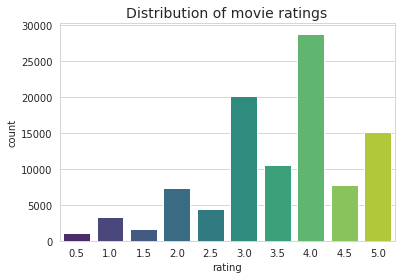

In [9]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

### Part 2: Top N recommender